In [1]:
import numpy as np
import pandas as pd
from faker import Faker
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.linalg as la
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

In [2]:
# PPM-Anon
def anonimization(data):
    #calculate the mean of each column
    mean = np.array(np.mean(data, axis=0).T)

    # center data
    data_centered = data - mean

    # calculate the covariance matrix
    cov_matrix = np.cov(data_centered.astype(float), rowvar=False)
   
    # calculate the eignvalues and eignvectors
    evals, evecs = la.eigh(cov_matrix)

    # sort them
    idx = np.argsort(evals)[::-1]

    # Each columns of this matrix is an eingvector
    evecs = evecs[:,idx]
    evals = evals[idx]

    # explained variance
    variance_retained=np.cumsum(evals)/np.sum(evals)

    # calculate the transformed data
    data_transformed=np.dot(evecs.T, data_centered.T).T

    # randomize eignvectors
    new_evecs = evecs.copy().T
    # for i in range(len(new_evecs)):
    #     np.random.shuffle(new_evecs[i])
    new_evecs = np.array(new_evecs).T

    # go back to the original dimension
    data_original_dimension = np.dot(data_transformed, new_evecs.T) 
    data_original_dimension += mean

    return data_original_dimension

In [3]:
# X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
# clustering = AgglomerativeClustering(n_clusters=3).fit(X)
# clustering.labels_

In [4]:
def find_clusters(X, clustering):   
    # Kmean = KMeans(n_clusters=k)
    clustering.fit(X)
    return clustering.labels_

In [5]:
def anonimization_clustering(data, clustering):
    # generate K data clusters
    clusters = find_clusters(data, clustering)

    # bucketize the index of each cluster
    indices = dict()
    for i in range(len(clusters)):
        if clusters[i] not in indices.keys():
            indices[ clusters[i] ] = []    
        indices[ clusters[i] ].append(i)

    data_anonymized = None

    # anonymize each cluster individually
    for k in indices.keys():
        if data_anonymized is None:
            data_anonymized = anonimization(data[ indices[k] ])
            empty_flag = False
        else:
            data_anonymized = np.concatenate((data_anonymized, anonimization(data[ indices[k] ]) ), axis=0)

    return data_anonymized

In [6]:
class Hash:
    def __init__(self, s: str):
        self.p, self.m, self.hash = 31, 10**9 + 7, 0
        self.compute_hashes(s)
 
    def compute_hashes(self, s: str):
        hash = 0
        for ch in s:
            value = ord(ch)
            hash = (hash * self.p + value) % self.m
        self.hash = hash
 
    def __eq__(self, other):
        return self.hash == other.hash
 
    def __str__(self):
        return f'({self.hash})'
 
def get_hash_value(s: str):
    return Hash(s).hash

print(get_hash_value("abc"))

96354


In [7]:
def create_dataset(num_of_rows, number_of_columns, faker):
    dataset = []
    for row in range(num_of_rows):
        line = []
        for col in range(number_of_columns):
            name = faker.name()
            line.append(name)
        dataset.append(line)
    dataset = pd.DataFrame(dataset)
    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            dataset.iloc[i, j] = get_hash_value(dataset.iloc[i, j])
    return np.array(dataset)

In [8]:
Faker.seed(123)
fake = Faker()

In [9]:
rows = [125, 250, 500, 1000, 2000, 4000]
# rows = []
# for r in range(200, 7000, 500):
#     rows.append(r)
x, y_kmeans, y_agglomerative, y_spectral, y_affinity, y_dbscan, y_meanshift = [], [], [], [], [], [], []


In [10]:
for row in rows:
    dataset = create_dataset(row, 10, fake)
    
    start_time = time.time()
    dataset = anonimization_clustering(dataset, AgglomerativeClustering(n_clusters=3))
    total_time = time.time() - start_time
    y_agglomerative.append(total_time)

    start_time = time.time()
    dataset = anonimization_clustering(dataset, KMeans(n_clusters=3))
    total_time = time.time() - start_time
    y_kmeans.append(total_time)

    start_time = time.time()
    dataset = anonimization_clustering(dataset, SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0))
    total_time = time.time() - start_time
    y_spectral.append(total_time)

    start_time = time.time()
    dataset = anonimization_clustering(dataset, AffinityPropagation(random_state=5))
    total_time = time.time() - start_time
    y_affinity.append(total_time)

    start_time = time.time()
    dataset = anonimization_clustering(dataset, DBSCAN(eps=3, min_samples=2))
    total_time = time.time() - start_time
    y_dbscan.append(total_time)

    # start_time = time.time()
    # dataset = anonimization_clustering(dataset, clustering = MeanShift(bandwidth=2))
    # total_time = time.time() - start_time
    # y_meanshift.append(total_time)

    x.append(row)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-p

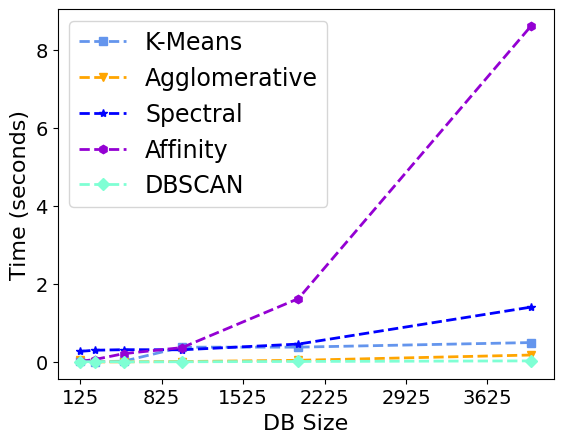

In [47]:
plt.plot(x, y_kmeans, color='cornflowerblue', marker='s', label='K-Means', linestyle='--', linewidth=2)
plt.plot(x, y_agglomerative, color='orange', marker='v', label='Agglomerative', linestyle='--', linewidth=2)
plt.plot(x, y_spectral, color='blue', marker='*', label='Spectral', linestyle='--', linewidth=2)
plt.plot(x, y_affinity, color='darkviolet', marker='h', label='Affinity', linestyle='--', linewidth=2)
plt.plot(x, y_dbscan, color='aquamarine', marker='D', label='DBSCAN', linestyle='--', linewidth=2)
# plt.plot(x, y_meanshift, color='pink', marker='*', label='Mean Shift')

xlab = []
l = 125
while l <= 4000:
    xlab.append(l)
    l += 700

plt.xticks(xlab)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.ylabel('Time (milliseconds)', fontsize=20)
# plt.xlabel('DB Size', fontsize=20)
# plt.title('', fontsize=20)

plt.ylabel('Time (seconds)', fontsize=16)
plt.xlabel('DB Size', fontsize=16)
# plt.title('Anonymization - Clustering Algorithms')
plt.legend(fontsize=17)

In [12]:

plt.show()